In [ ]:
%load_ext autoreload
%autoreload 2

### Load the graph

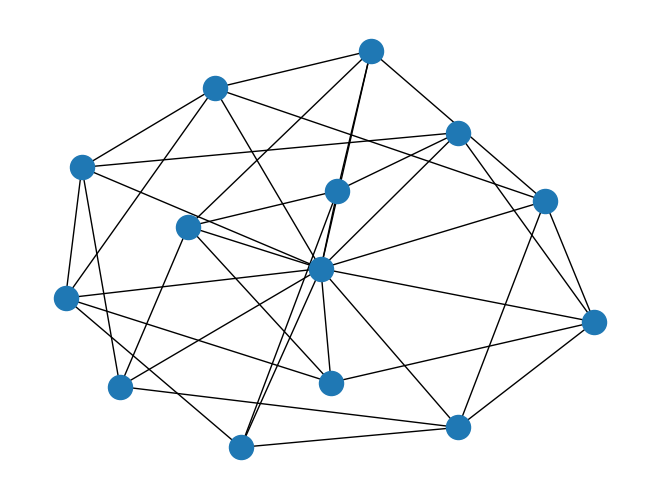

In [11]:
import networkx as nx
G14 = nx.from_graph6_bytes(b'>>graph6<<M{dAH?`AoXAgCg~~_')
nx.draw(G14)

### Define the circuit

We use a GHZ state $|\psi\rangle = 1/\sqrt{2} (\ket{0000} + \ket{1111})$ as our shared state. Then, we apply the U3Ry measurement layer that we used in the non-local games paper \[1\].

\[1\] [ArXiv 2311.01363](https://arxiv.org/abs/2311.01363)

In [12]:
import pennylane as qml
import jax
from jax import numpy as jnp

n_wires = 4
dev = qml.device("default.qubit", wires=n_wires)

def u3ry(params: jax.Array, wires):
    """U3Ry measurement layer from nonlocalgames paper"""
    # Params should have shape (wires, 4)
    qml.U3(*params[0, 0:3], wires=wires[0])
    qml.U3(*params[1, 0:3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[0, 3], wires=wires[0])
    qml.RY(params[1, 3], wires=wires[1])

@jax.jit
def conj_params(params: jax.Array):
    """Conjugates measurement parameters"""
    # Params has shape (wires, 4)
    copy = params.copy()
    copy = copy.at[:, 1:3].set(-copy[:, 1:3])
    return copy

def ghz(wires):
    """GHZ state of 4 qubits"""
    qml.Hadamard(wires=wires[0])

    for ctrl, tgt in zip(wires[:-1], wires[1:]):
        qml.CNOT(wires=[ctrl, tgt])

def cluster(wires):
    """Cluster state of 4 qubits"""
    for wire in wires:
        qml.Hadamard(wires=wire)
    
    qml.CZ(wires=[wires[0], wires[1]])
    qml.CZ(wires=[wires[2], wires[3]])
    qml.CZ(wires=[wires[1], wires[2]])

    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[3])

def pcc():
    projectors = []

    for c in range(4):
        b1, b0 = c // 2, c % 2
        proj = qml.Projector(state=[b1, b0, b1, b0], wires=(0, 1, 2, 3))
        projectors.append(proj)
    
    return sum(projectors)

Pcc = pcc()

@qml.qnode(dev, interface='jax')
def circuit(params: jax.Array, va: int, vb: int):
    # State preparation
    ghz(wires=(0, 1, 2, 3))

    qml.Barrier(wires=(0, 1, 2, 3))

    # Apply measurement layer
    u3ry(params[va], wires=(0, 1))
    u3ry(conj_params(params[vb]), wires=(2, 3))

    return qml.expval(Pcc)

def value(G14: nx.Graph, params: jax.Array):
    Q = len(G14) + 2 * len(G14.edges)
    val = 0
    for v in G14:
        val += circuit(params, v, v)
    
    for va, vb in G14.edges:
        val += 1 - circuit(params, va, vb)
        val += 1 - circuit(params, vb, va)
    
    return val / Q

value = jax.jit(value, static_argnums=(0,))

### Testing our function

Here we create random parameters $\phi$ of shape `(vertices, qubits per player, gates per qubit)`. Then we calculate the value of the game $V(\phi)$. Finally, we test if we can autodiff through the computation using the jax function `value_and_grad`, which returns a function `f` that returns both the game value and the derivative w.r.t the parameters.

In [13]:
from jax import random

key = random.PRNGKey(42)
params = random.normal(key, (14, 2, 4))

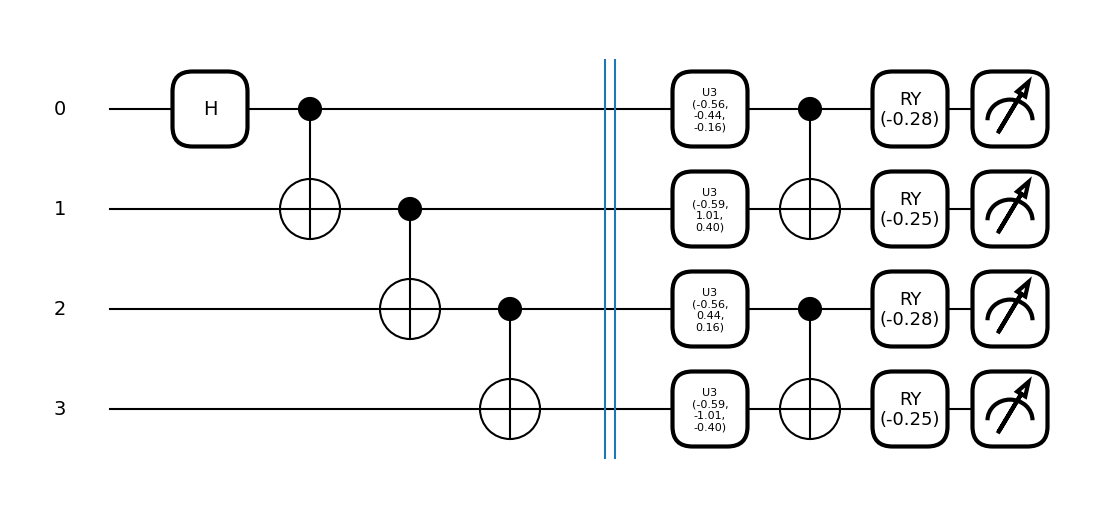

In [14]:
import matplotlib.pyplot as plt

qml.draw_mpl(circuit, decimals=2)(params, 0, 0)
plt.show()

In [15]:
v_grad = jax.value_and_grad(value, argnums=1)
v, grad = v_grad(G14, params)
v

Array(0.70196086, dtype=float32)

### Optimization

We'll use gradient descent on the parameters $\phi$. We define the loss function
$$
\mathcal{L}(\phi) = 1 - V(\phi)
$$

In [16]:
import jaxopt

@jax.jit
def loss(params):
    return 1 - value(G14, params)

solver = jaxopt.GradientDescent(loss)
result = solver.run(params)
value(G14, result.params)

Array(0.93346995, dtype=float32)

### Evaluation

Test the circuit and see which questions it fails on

In [17]:
shots = 10000
shot_device = qml.device('default.qubit', shots=shots)

@qml.qnode(shot_device, interface='jax')
def sample(params: jax.Array, va: int, vb: int):
    # State preparation
    ghz(wires=(0, 1, 2, 3))

    qml.Barrier(wires=(0, 1, 2, 3))

    # Apply measurement layer
    u3ry(params[va], wires=(0, 1))
    u3ry(conj_params(params[vb]), wires=(2, 3))

    return qml.sample()

def count_same(s: jax.Array):
    a = 2 ** s[:, 0] + s[:, 1]
    b = 2 ** s[:, 2] + s[:, 3]
    return jnp.sum(a == b).item()

G = nx.Graph()

for v in G14:
    w = count_same(sample(result.params, v, v)) / shots
    G.add_node(v, weight=w)

for va, vb in G14.edges:
    w1 = (shots - count_same(sample(result.params, va, vb))) / shots
    w2 = (shots - count_same(sample(result.params, vb, va))) / shots
    G.add_edge(
        va, vb,
        weight=jnp.array([w1, w2]).mean()
    )

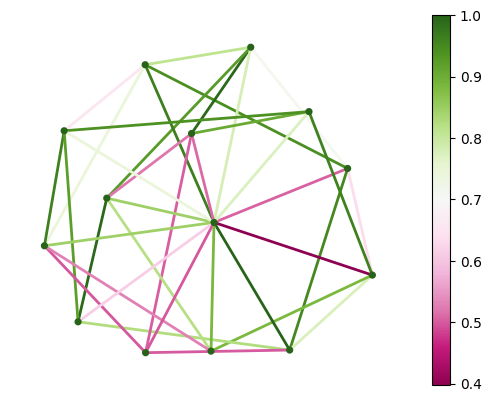

In [18]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Colormap
from matplotlib.collections import LineCollection, PathCollection

def draw_graph(G: nx.Graph,
               cmap: str | Colormap = 'PiYG',
               initial_pos = None,
               vmin = None,
               vmax = None):
    '''Draws a graph and colors the nodes and vertices based on the `weight` attribute.
    
    Args:
        G: Graph to draw. Both nodes and vertices should have a `weight` attribute
        
        cmap: The colormap to use. Can be a matplotlib string or a Colormap instance.
    
    Returns:
        The Axes of the new figure
    '''
    if isinstance(cmap, str):
        cmap = colormaps.get_cmap(cmap)

    node_colors = list(map(lambda it: it[-1], G.nodes.data('weight')))
    edge_colors = list(map(lambda it: it[-1], G.edges.data('weight')))

    vmin = vmin or min([*node_colors, *edge_colors])
    vmax = vmax or max([*node_colors, *edge_colors])
    scaled = (jnp.array(node_colors) - vmin) / (vmax - vmin)
    node_colors = cmap(jnp.clip(scaled, 0, 1))

    scaled = (jnp.array(edge_colors) - vmin) / (vmax - vmin)
    edge_colors = cmap(jnp.clip(scaled, 0, 1))

    pos = nx.kamada_kawai_layout(G, weight=None, pos=initial_pos)
    nodes: PathCollection = nx.draw_networkx_nodes(
        G,
        pos,
        node_color=node_colors,
        linewidths=2,
        node_size=10,
    )
    edges: LineCollection = nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_colors,
        edge_cmap=cmap,
        edge_vmin=vmin,
        edge_vmax=vmax,
        width=2,
    )
    # edges.set_array(edge_colors)

    ax = plt.gca()
    ax.set_axis_off()
    plt.colorbar(edges, ax=ax)
    return ax

draw_graph(G)
plt.show()

### Export the circuits

Use the built-in mechanisms for pennylane to export circuits as qasm files